In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

daily_sleep = pd.read_csv("results/daily_sleep_summary.csv")
sleep_df = pd.read_csv("results/sleep_df.csv")

print("✅ Data loaded:")
print(f"Daily summary rows: {len(daily_sleep)}")
print(f"Sleep records: {len(sleep_df)}")


✅ Data loaded:
Daily summary rows: 78
Sleep records: 1583


In [21]:
sleep_df["startDate"] = pd.to_datetime(sleep_df["startDate"])
sleep_df["endDate"] = pd.to_datetime(sleep_df["endDate"])
sleep_df["duration_h"] = (sleep_df["endDate"] - sleep_df["startDate"]).dt.total_seconds() / 3600
sleep_df["date"] = sleep_df["startDate"].dt.date

sleep_df["stage"] = sleep_df["value"].astype(str).str.lower()

stage_map = {
    "core": "Core_h",
    "light": "Core_h",
    "asleep": "Core_h",

    "deep": "Deep_h",

    "rem": "REM_h",

    "awake": "Awake_h",
    "inbed": "Awake_h",
}

sleep_df["stage_mapped"] = sleep_df["stage"].map(stage_map)

stages_clean = sleep_df.dropna(subset=["stage_mapped"])


In [22]:
stage_summary = stages_clean.pivot_table(
    index="date",
    columns="stage_mapped",
    values="duration_h",
    aggfunc="sum",
    fill_value=0
).reset_index()

for col in ["REM_h", "Deep_h", "Core_h", "Awake_h"]:
    if col not in stage_summary.columns:
        stage_summary[col] = 0

stage_summary["total_h"] = (
    stage_summary["REM_h"] +
    stage_summary["Deep_h"] +
    stage_summary["Core_h"] +
    stage_summary["Awake_h"]
)

stage_summary["REM_pct"] = stage_summary["REM_h"] / stage_summary["total_h"]
stage_summary["Deep_pct"] = stage_summary["Deep_h"] / stage_summary["total_h"]
stage_summary["Core_pct"] = stage_summary["Core_h"] / stage_summary["total_h"]
stage_summary["Awake_pct"] = stage_summary["Awake_h"] / stage_summary["total_h"]

stage_summary.tail()


stage_mapped,date,REM_h,Deep_h,Core_h,Awake_h,total_h,REM_pct,Deep_pct,Core_pct,Awake_pct


In [23]:
def compute_sleep_quality(df):
    df = df.copy()

    df["sleep_quality"] = (
        df["Deep_h"] * 2.0 +      
        df["REM_h"] * 1.5 +       
        df["Core_h"] * 1.0 -     
        df["Awake_h"] * 1.2       
    )

    df["sleep_quality"] = df["sleep_quality"].clip(lower=0)
    return df

stage_scored = compute_sleep_quality(stage_summary)
stage_scored.tail()


stage_mapped,date,REM_h,Deep_h,Core_h,Awake_h,total_h,REM_pct,Deep_pct,Core_pct,Awake_pct,sleep_quality


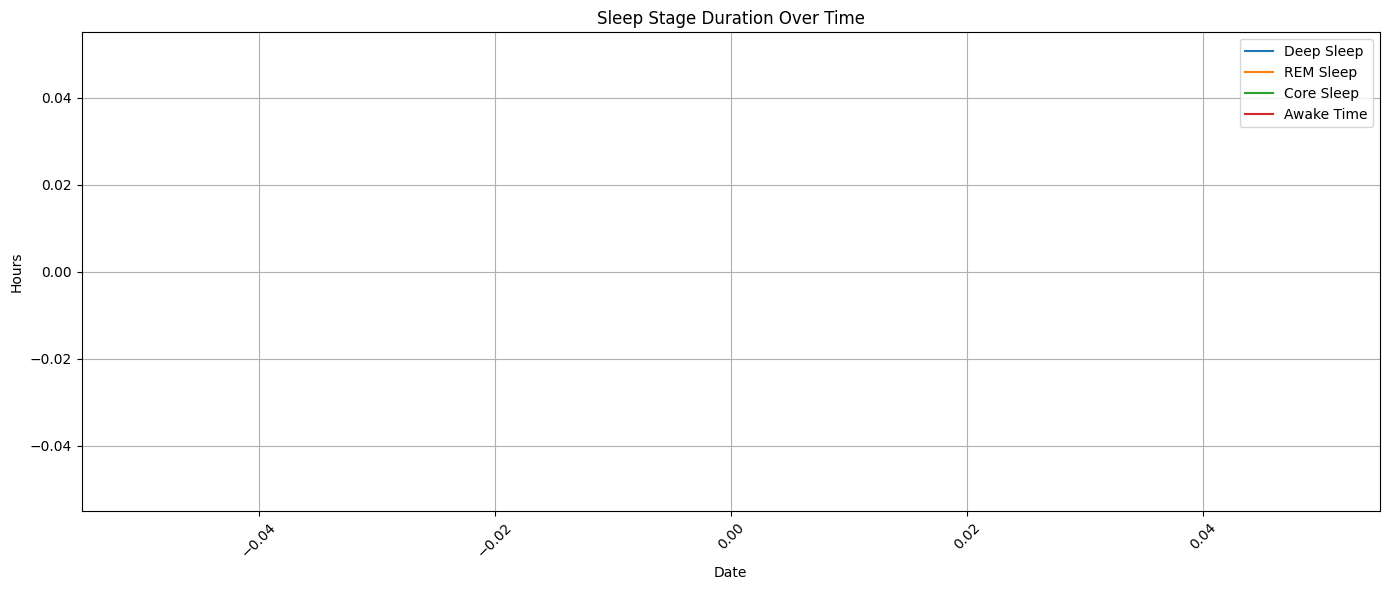

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(stage_scored["date"], stage_scored["Deep_h"], label="Deep Sleep")
plt.plot(stage_scored["date"], stage_scored["REM_h"], label="REM Sleep")
plt.plot(stage_scored["date"], stage_scored["Core_h"], label="Core Sleep")
plt.plot(stage_scored["date"], stage_scored["Awake_h"], label="Awake Time")

plt.legend()
plt.title("Sleep Stage Duration Over Time")
plt.xlabel("Date")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


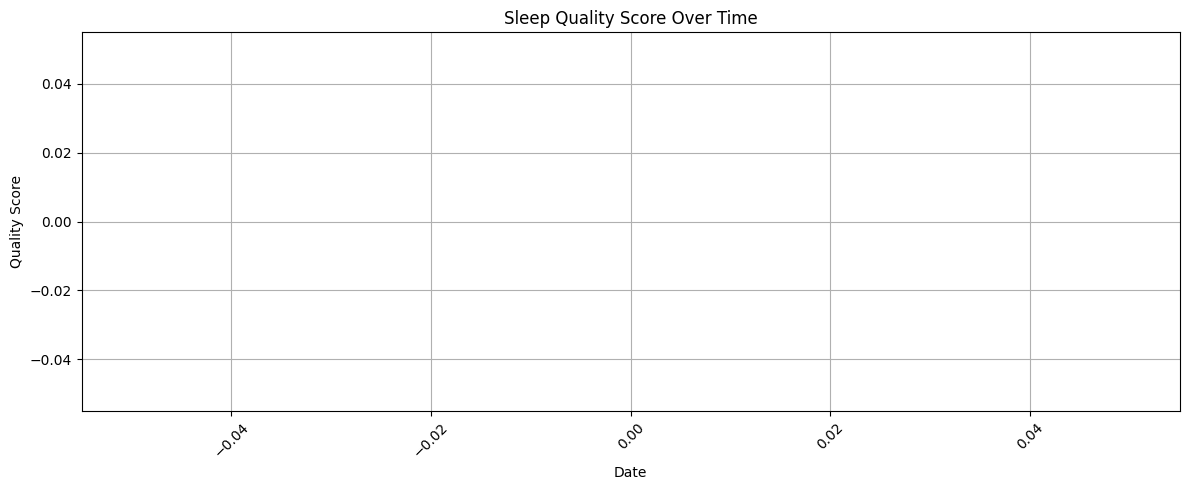

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(stage_scored["date"], stage_scored["sleep_quality"], marker="o")
plt.title("Sleep Quality Score Over Time")
plt.xlabel("Date")
plt.ylabel("Quality Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


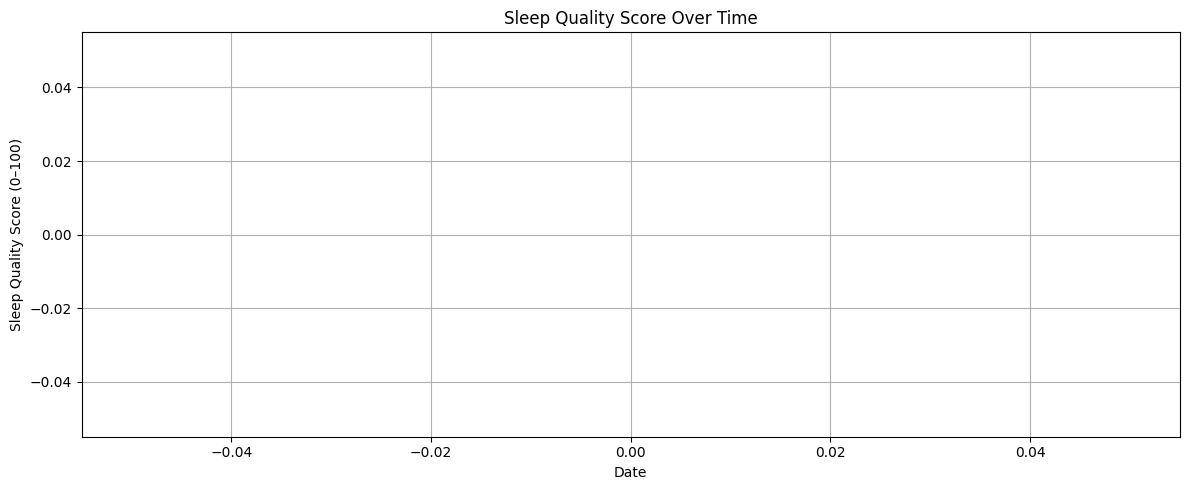

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(stage_scored["date"], stage_scored["sleep_quality"], marker='o')
plt.title("Sleep Quality Score Over Time")
plt.xlabel("Date")
plt.ylabel("Sleep Quality Score (0–100)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
merged = daily_sleep.merge(stage_scored, on="date", how="left")

print("✅ Merged dataset:")
merged.tail()


✅ Merged dataset:


,date,HKCategoryValueSleepAnalysisAsleepCore,HKCategoryValueSleepAnalysisAsleepDeep,HKCategoryValueSleepAnalysisAsleepREM,HKCategoryValueSleepAnalysisAsleepUnspecified,HKCategoryValueSleepAnalysisAwake,total_sleep_hours,REM_h,Deep_h,Core_h,Awake_h,total_h,REM_pct,Deep_pct,Core_pct,Awake_pct,sleep_quality
73,2025-10-18,3.208889,1.213611,1.487500,0.0,0.366111,6.276111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,2025-10-19,4.704444,1.371667,2.959722,0.0,0.016389,9.052222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,2025-10-20,2.519444,1.886667,1.845278,0.0,0.174167,6.425556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,2025-10-21,3.175278,1.687222,1.878611,0.0,0.025000,6.766111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2025-10-22,3.308333,1.911667,2.726667,0.0,0.191111,8.137778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

summary_text = merged[[
    "date", "total_sleep_hours", "Deep_h", "REM_h", "Core_h", "Awake_h", "sleep_quality"
]].tail(7).to_string(index=False)

prompt = (
    "Analyze the user's past 7 nights of sleep stage patterns. Identify trends in REM, Deep, "
    "Core sleep, and awakenings. Comment on overall sleep quality and provide 2–3 practical tips."
)

response = client.chat.completions.create(
    model=os.getenv("GPT_MODEL"),
    messages=[
        {"role": "system", "content": "You are an expert sleep scientist."},
        {"role": "user", "content": f"{prompt}\n\nData:\n{summary_text}"}
    ],
    temperature=0.6
)

print("🧠 AI Sleep Stage Interpretation:\n")
print(response.choices[0].message.content)


🧠 AI Sleep Stage Interpretation:

Your sleep appears balanced. Try maintaining this routine and monitor stress levels.
